In [0]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization
from keras.utils import np_utils
from keras.datasets import cifar10
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, UpSampling2D, concatenate 
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [0]:
import keras
from keras.datasets import cifar10
from keras.utils import to_categorical

# Load the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [24]:
num_classes = 10
y_train=to_categorical(y_train,num_classes)
y_test=to_categorical(y_test,num_classes) 

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

print('Original training data shape: {}'.format(x_train.shape))
print('Training label shape: {}'.format(y_train.shape))

Original training data shape: (50000, 32, 32, 3)
Training label shape: (50000, 10)


# UNET MODEL

In [6]:
inputs = Input((32,32,3))

#convolution and pool (downsample) #1
c_0 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
p_0 = MaxPooling2D(pool_size=(2, 2))(c_0)
#convolution and pool (downsample) #2
c_1 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_0)
p_1 = MaxPooling2D(pool_size=(2, 2))(c_1)
#convolution and pool (downsample) #3
c_2 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_1)
p_2 = MaxPooling2D(pool_size=(2, 2))(c_2)
#convolution and pool (downsample), dropout #4
c_3 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_2)
d_0 = Dropout(0.5)(c_3)
p_3 = MaxPooling2D(pool_size=(2, 2))(d_0)
#convolution and  dropout #5
c_4 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(p_3)
d_1 = Dropout(0.5)(c_4)

# upsample
u_0 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(d_1))
m_0 = concatenate([d_0,u_0], axis = 3)
uc_0 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_0)

u_1 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(uc_0))
m_1 = concatenate([c_2,u_1], axis = 3)
uc_1 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_1)

u_2 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(uc_1))
m_2 = concatenate([c_1,u_2], axis = 3)
uc_2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_2)

u_3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(uc_2))
m_3 = concatenate([c_0,u_3], axis = 3)
uc_3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(m_3)
out = Conv2D(3, 3,  padding = 'same')(uc_3)

model = Model(inputs = inputs, outputs = out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  73856       max_pooling2d[0][0]              
______________________________________________________________________________________________

In [47]:
model2 = Model(inputs = inputs, outputs = out)
model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1792        input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 16, 16, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 128)  73856       max_pooling2d[0][0]              
____________________________________________________________________________________________

DENOISER TO TEST

In [0]:
import numpy as np

x_train_noise = x_train + np.random.normal(size = x_train.shape, scale = 0.1)
x_test_noise = x_test + np.random.normal(size = x_test.shape, scale = 0.1)

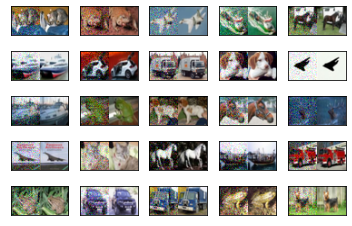

In [8]:
import matplotlib.pyplot as plt

N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_test_noise[idx], 0, 1), np.clip(x_test[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [9]:
model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(x_train_noise, x_train, batch_size=32, epochs=3, validation_split=0.2)

Epoch 1/3
1250/1250 [==============================] - 115s 92ms/step - loss: 0.0602 - mae: 0.0602 - val_loss: 0.0332 - val_mae: 0.0332
Epoch 2/3
1250/1250 [==============================] - 114s 91ms/step - loss: 0.0321 - mae: 0.0321 - val_loss: 0.0313 - val_mae: 0.0313
Epoch 3/3
1250/1250 [==============================] - 114s 91ms/step - loss: 0.0308 - mae: 0.0308 - val_loss: 0.0306 - val_mae: 0.0306


In [0]:
pred = model.predict(x_test_noise)

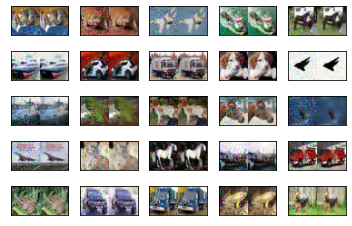

In [11]:
import matplotlib.pyplot as plt

N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_test_noise[idx], 0, 1), np.clip(pred[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

# FOURIER

In [0]:

import numpy as np
from numpy import isneginf
from scipy.stats import iqr 

def compute_mag_phase(toBeTransfromed):
    dft = np.fft.fft2(toBeTransfromed)
    dft_shift = np.fft.fftshift(dft)
    mag = np.abs(dft_shift)
    ang = np.angle(dft_shift)
    return mag, ang

def reconstruct(mag,ang):
    combined = np.multiply(mag, np.exp(1j*ang))
    #combinedReal = np.real(combined)
    #combinedImag = np.imag(combined)
    fftx = np.fft.ifftshift(combined)
    ffty = np.fft.ifft2(fftx)
    imgCombined = np.abs(ffty)
    return imgCombined

def pre_process_mag(dataset):
    mag = np.zeros(dataset.shape)
    phase = np.zeros(dataset.shape)
    x= 0
    for i in range(0,dataset.shape[0]):
      mag[i,:,:],phase[i,:,:] = compute_mag_phase(dataset[i])
    return mag,phase


def reconstructAll(mag, ang):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag[i,:,:],ang[i,:,:])
    return recon

## Effect of training on magnitude only data

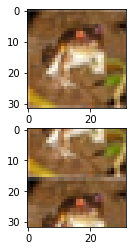

In [0]:
mag,ang = pre_process_mag(x_train[0])
recon = reconstruct(mag,ang)

plt.subplot(211)
plt.imshow(x_train[0])
plt.subplot(212)
plt.imshow(recon)

In [8]:
X_train_mag,X_train_phase = pre_process_mag(x_train)
X_test_mag,X_test_phase = pre_process_mag(x_test)
print(X_train_mag.shape)

(50000, 32, 32, 3)


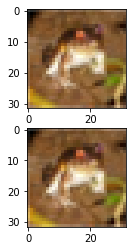

In [0]:
recons = reconstructAll(X_train_mag, X_train_phase)
plt.subplot(211)
plt.imshow(x_train[0])
plt.subplot(212)
plt.imshow(recons[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


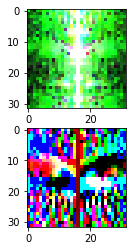

In [0]:
plt.subplot(211)
plt.imshow(X_train_mag[0])
plt.subplot(212)
plt.imshow(X_train_phase[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


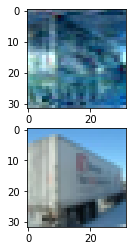

In [0]:
recon1 = reconstruct(X_train_mag[0],X_train_phase[15])
plt.subplot(211)
plt.imshow(recon1)
recon2 = reconstruct(X_train_mag[15],X_train_phase[15])
plt.subplot(212)
plt.imshow(recon2)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_mag, x_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
1250/1250 [==============================] - 117s 94ms/step - loss: 0.2029 - mae: 0.2029 - val_loss: 0.1341 - val_mae: 0.1341
Epoch 2/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1331 - mae: 0.1331 - val_loss: 0.1331 - val_mae: 0.1331
Epoch 3/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1286 - mae: 0.1286 - val_loss: 0.1241 - val_mae: 0.1241
Epoch 4/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1260 - mae: 0.1260 - val_loss: 0.1240 - val_mae: 0.1240
Epoch 5/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.1245 - mae: 0.1245 - val_loss: 0.1224 - val_mae: 0.1224
Epoch 6/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.1234 - mae: 0.1234 - val_loss: 0.1214 - val_mae: 0.1214
Epoch 7/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.1224 - mae: 0.1224 - val_loss: 0.1209 - val_mae: 0.1209
Epoch 8/50
1250/1250 [===================

In [10]:
score = model.evaluate(X_test_mag, x_test, verbose=0)

print(score)

[0.12339834868907928, 0.12339834868907928]


Train data

In [0]:
pred = model.predict(X_train_mag)

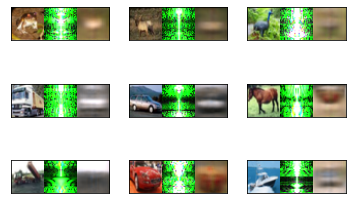

In [12]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_mag[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Test data

In [0]:
pred = model.predict(X_test_mag)

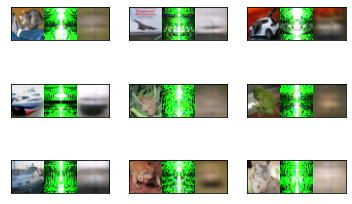

In [14]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(X_test_mag[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

## Effect of training on phase only data

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_phase, x_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1529 - mae: 0.1529 - val_loss: 0.1578 - val_mae: 0.1578
Epoch 2/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.1509 - mae: 0.1509 - val_loss: 0.1576 - val_mae: 0.1576
Epoch 3/50
1250/1250 [==============================] - 116s 92ms/step - loss: 0.1491 - mae: 0.1491 - val_loss: 0.1567 - val_mae: 0.1567
Epoch 4/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1473 - mae: 0.1473 - val_loss: 0.1557 - val_mae: 0.1557
Epoch 5/50
1250/1250 [==============================] - 116s 92ms/step - loss: 0.1454 - mae: 0.1454 - val_loss: 0.1561 - val_mae: 0.1561
Epoch 6/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.1438 - mae: 0.1438 - val_loss: 0.1552 - val_mae: 0.1552
Epoch 7/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.1422 - mae: 0.1422 - val_loss: 0.1561 - val_mae: 0.1561
Epoch 8/50
1250/1250 [===================

In [17]:
score = model.evaluate(X_test_phase, x_test, verbose=0)

print(score)

[0.15558646619319916, 0.15558646619319916]


On training data

In [0]:
pred = model.predict(X_train_phase)

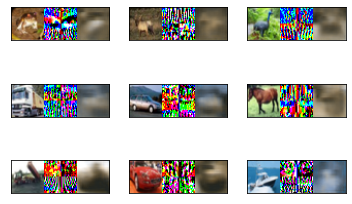

In [19]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_phase[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

On testing data

In [0]:
pred = model.predict(X_test_phase)

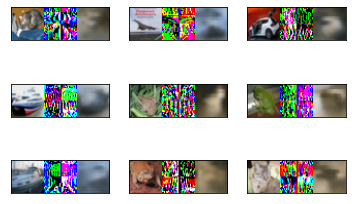

In [26]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(X_test_phase[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

## Effect of training on constant phase from another picture

In [0]:
def reconstructAllX(mag, ang):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag[i,:,:],ang[100,:,:])
    return recon

In [0]:
X_train_corrupt = reconstructAllX(X_train_mag,X_train_phase)
X_test_corrupt = reconstructAllX(X_test_mag,X_test_phase)

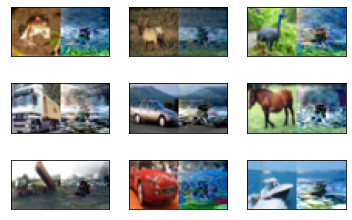

In [29]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train[idx], 0, 1), np.clip(X_train_corrupt[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [30]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_corrupt, x_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])


Epoch 1/50
1250/1250 [==============================] - 117s 94ms/step - loss: 0.1300 - mae: 0.1300 - val_loss: 0.1220 - val_mae: 0.1220
Epoch 2/50
1250/1250 [==============================] - 117s 93ms/step - loss: 0.1223 - mae: 0.1223 - val_loss: 0.1206 - val_mae: 0.1206
Epoch 3/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1203 - mae: 0.1203 - val_loss: 0.1184 - val_mae: 0.1184
Epoch 4/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1191 - mae: 0.1191 - val_loss: 0.1185 - val_mae: 0.1185
Epoch 5/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1184 - mae: 0.1184 - val_loss: 0.1169 - val_mae: 0.1169
Epoch 6/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1178 - mae: 0.1178 - val_loss: 0.1169 - val_mae: 0.1169
Epoch 7/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1171 - mae: 0.1171 - val_loss: 0.1169 - val_mae: 0.1169
Epoch 8/50
1250/1250 [===================

In [31]:
score = model.evaluate(X_test_corrupt, x_test, verbose=0)

print(score)

[0.13525107502937317, 0.13525107502937317]


Train

In [0]:
pred = model.predict(X_train_corrupt)


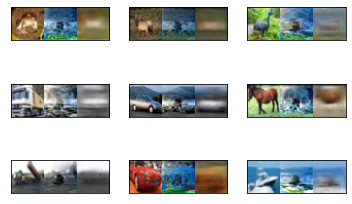

In [62]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Test

In [0]:
pred = model.predict(X_test_corrupt)

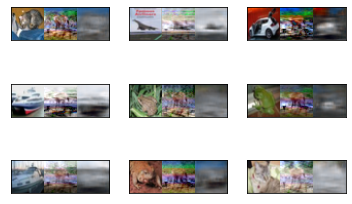

In [64]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(X_test_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Above shows recovery when phase is set constant. Might work better with one type of image. Lets see how it performs when magnitude is constant.

## Effect of training on constant magnitude from another picture

In [0]:
def reconstructAllX2A(mag, ang):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag[100,:,:],ang[i,:,:])
    return recon, mag[100,:,:]

def reconstructAllX2B(mag, ang,magx):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(magx,ang[i,:,:])
    return recon

In [0]:
X_train_corrupt, magx = reconstructAllX2A(X_train_mag,X_train_phase)
X_test_corrupt = reconstructAllX2B(X_test_mag,X_test_phase, magx)

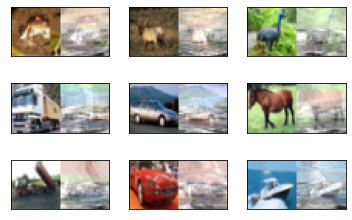

In [34]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train[idx], 0, 1), np.clip(X_train_corrupt[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [35]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_corrupt, x_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
1250/1250 [==============================] - 117s 94ms/step - loss: 0.1535 - mae: 0.1535 - val_loss: 0.1381 - val_mae: 0.1381
Epoch 2/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1364 - mae: 0.1364 - val_loss: 0.1332 - val_mae: 0.1332
Epoch 3/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1312 - mae: 0.1312 - val_loss: 0.1291 - val_mae: 0.1291
Epoch 4/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1283 - mae: 0.1283 - val_loss: 0.1276 - val_mae: 0.1276
Epoch 5/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1259 - mae: 0.1259 - val_loss: 0.1265 - val_mae: 0.1265
Epoch 6/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.1241 - mae: 0.1241 - val_loss: 0.1259 - val_mae: 0.1259
Epoch 7/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.1222 - mae: 0.1222 - val_loss: 0.1242 - val_mae: 0.1242
Epoch 8/50
1250/1250 [===================

In [36]:
score = model.evaluate(X_test_corrupt, x_test, verbose=0)

print(score)

[0.1255359798669815, 0.1255359798669815]


Train

In [0]:
pred = model.predict(X_train_corrupt)


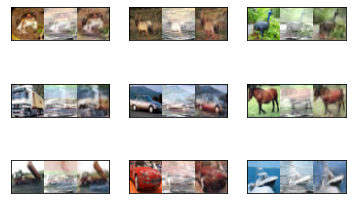

In [94]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Test

In [0]:
pred = model.predict(X_test_corrupt)


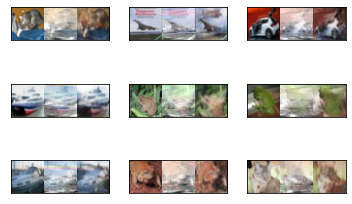

In [96]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(X_test_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Recombing original phase with new image magnitude

In [0]:
X_test_mag,X_test_phase = pre_process_mag(pred)
del X_test_phase
X_test_magx,X_test_phase = pre_process_mag(x_test)
del X_test_magx
recons = reconstructAll(X_test_mag, X_test_phase)

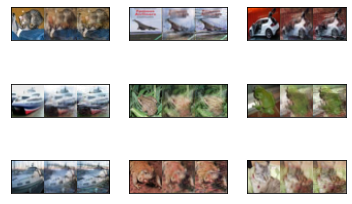

In [98]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(pred[idx],0,1)))
    se2 =  np.hstack((se, np.clip(recons[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
X_train_corrupt2 = model.predict(X_train_corrupt)
X_test_corrupt2 = model.predict(X_test_corrupt)

In [0]:
X_train_mag,X_train_phase = pre_process_mag(X_train_corrupt2)  # get mag from prediction
del X_train_phase
X_train_magx,X_train_phase = pre_process_mag(x_train)   #get phase from data
del X_train_magx
X_train_corrupt3 = reconstructAll(X_train_mag, X_train_phase)  #combine

X_test_mag,X_test_phase = pre_process_mag(X_test_corrupt2)
del X_test_phase
X_test_magx,X_test_phase = pre_process_mag(x_test)
del X_test_magx
X_test_corrupt3 = reconstructAll(X_test_mag, X_test_phase)

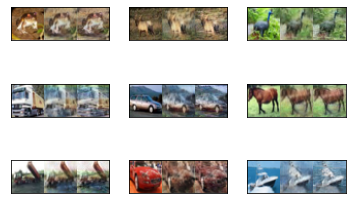

In [39]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_corrupt2[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_train_corrupt3[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

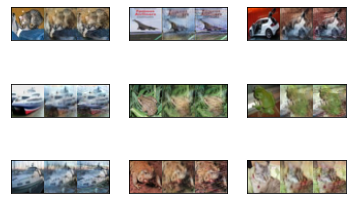

In [40]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(X_test_corrupt2[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_test_corrupt3[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [45]:
from sklearn.metrics import mean_absolute_error

print(x_test.shape)

mae = (np.sum(np.absolute((x_test - X_test_corrupt3))))/(10000*32*32*3)

print(mae)

(10000, 32, 32, 3)
0.12151393587524636


second order unet

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model2.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model2.fit(X_train_corrupt3, x_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.0959 - mae: 0.0959 - val_loss: 0.1154 - val_mae: 0.1154
Epoch 2/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.0941 - mae: 0.0941 - val_loss: 0.1155 - val_mae: 0.1155
Epoch 3/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.0930 - mae: 0.0930 - val_loss: 0.1148 - val_mae: 0.1148
Epoch 4/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.0923 - mae: 0.0923 - val_loss: 0.1149 - val_mae: 0.1149
Epoch 5/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.0914 - mae: 0.0914 - val_loss: 0.1144 - val_mae: 0.1144
Epoch 6/50
1250/1250 [==============================] - 116s 93ms/step - loss: 0.0907 - mae: 0.0907 - val_loss: 0.1152 - val_mae: 0.1152
Epoch 7/50
1250/1250 [==============================] - 115s 92ms/step - loss: 0.0898 - mae: 0.0898 - val_loss: 0.1150 - val_mae: 0.1150


In [49]:
score = model.evaluate(X_test_corrupt3, x_test, verbose=0)

print(score)

[0.11398742347955704, 0.11398742347955704]


In [0]:
pred = model2.predict(X_train_corrupt3)

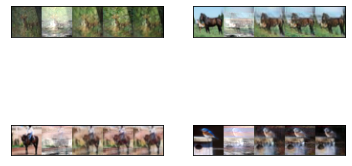

In [53]:
import matplotlib.pyplot as plt

N=2
start_val = 10# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_train_corrupt2[idx],0,1)))
    se3 =  np.hstack((se2, np.clip(X_train_corrupt3[idx],0,1)))
    se4 =  np.hstack((se3, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se4)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
pred = model2.predict(X_test_corrupt3)

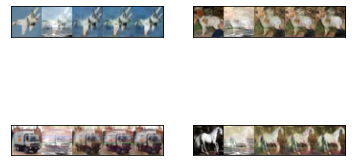

In [56]:
import matplotlib.pyplot as plt

N=2
start_val = 10# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(X_test_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_test_corrupt2[idx],0,1)))
    se3 =  np.hstack((se2, np.clip(X_test_corrupt3[idx],0,1)))
    se4 =  np.hstack((se3, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se4)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

## Constant magnitude 

What happens if we use constant magnitude?

In [0]:
import random
import numpy as np
np.random.seed(100)
const_mag = np.full((32, 32, 3), 1.2)
noise_mag = np.random.uniform(size = (32,32,3),low = 0.0, high = 7.0)

In [0]:
def reconstructAllX4(mag, ang):
    recon = np.zeros(ang.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag,ang[i])
    return recon

In [0]:
X_train_corrupt = reconstructAllX4(const_mag,X_train_phase)
X_test_corrupt = reconstructAllX4(const_mag,X_test_phase)

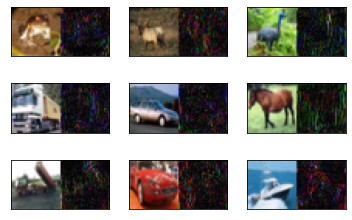

In [117]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train[idx], 0, 1), np.clip(X_train_corrupt[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [125]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_corrupt, x_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
1250/1250 [==============================] - 114s 91ms/step - loss: 0.1983 - mae: 0.1983 - val_loss: 0.1938 - val_mae: 0.1938
Epoch 2/50
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1910 - mae: 0.1910 - val_loss: 0.1904 - val_mae: 0.1904
Epoch 3/50
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1877 - mae: 0.1877 - val_loss: 0.1885 - val_mae: 0.1885
Epoch 4/50
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1850 - mae: 0.1850 - val_loss: 0.1866 - val_mae: 0.1866
Epoch 5/50
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1825 - mae: 0.1825 - val_loss: 0.1864 - val_mae: 0.1864
Epoch 6/50
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1801 - mae: 0.1801 - val_loss: 0.1871 - val_mae: 0.1871
Epoch 7/50
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1776 - mae: 0.1776 - val_loss: 0.1877 - val_mae: 0.1877


In [126]:
score = model2.evaluate(X_test_corrupt, x_test, verbose=0)

print(score)

[0.18723559379577637, 0.18723559379577637]


In [0]:
pred = model.predict(X_train_corrupt)

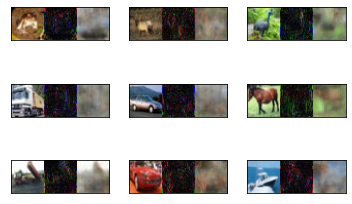

In [128]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
pred = model.predict(X_test_corrupt)

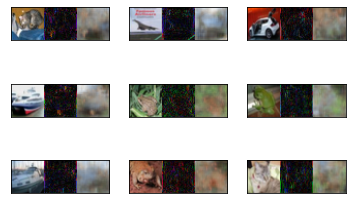

In [130]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(X_test_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

## Noise mag

In [0]:
X_train_corrupt = reconstructAllX4(noise_mag,X_train_phase)
X_test_corrupt = reconstructAllX4(noise_mag,X_test_phase)

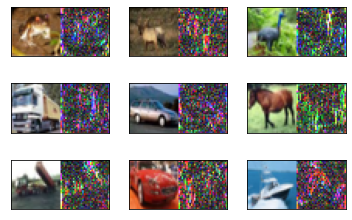

In [133]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train[idx], 0, 1), np.clip(X_train_corrupt[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [134]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_corrupt, x_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
1250/1250 [==============================] - 114s 91ms/step - loss: 0.1935 - mae: 0.1935 - val_loss: 0.1926 - val_mae: 0.1926
Epoch 2/50
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1871 - mae: 0.1871 - val_loss: 0.1907 - val_mae: 0.1907
Epoch 3/50
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1841 - mae: 0.1841 - val_loss: 0.1923 - val_mae: 0.1923
Epoch 4/50
1250/1250 [==============================] - 113s 90ms/step - loss: 0.1809 - mae: 0.1809 - val_loss: 0.1908 - val_mae: 0.1908


In [136]:
score = model.evaluate(X_test_corrupt, x_test, verbose=0)

print(score)

[0.1906593292951584, 0.1906593292951584]


In [0]:
pred = model.predict(X_train_corrupt)

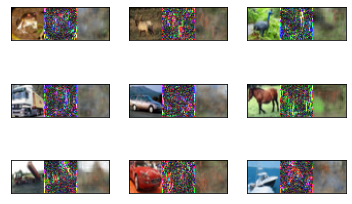

In [138]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
pred = model.predict(X_test_corrupt)

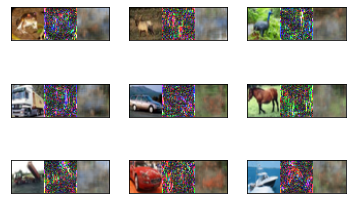

In [140]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
X_train_corrupt2 = model.predict(X_train_corrupt)
X_test_corrupt2 = model.predict(X_test_corrupt)

In [0]:
X_train_mag,X_train_phase = pre_process_mag(X_train_corrupt2)
del X_train_phase
X_train_magx,X_train_phase = pre_process_mag(x_train)
del X_train_magx
X_train_corrupt3 = reconstructAll(X_train_mag, X_train_phase)

X_test_mag,X_test_phase = pre_process_mag(X_test_corrupt2)
del X_test_phase
X_test_magx,X_test_phase = pre_process_mag(x_test)
del X_test_magx
X_test_corrupt3 = reconstructAll(X_test_mag, X_test_phase)

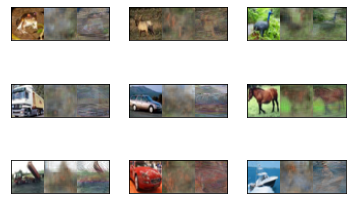

In [143]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_corrupt2[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_train_corrupt3[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

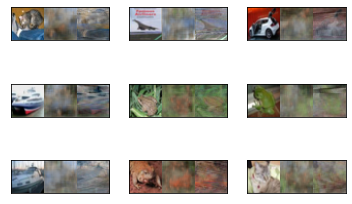

In [144]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(X_test_corrupt2[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_test_corrupt3[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [145]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss',patience=2)

model2.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model2.fit(X_train_corrupt3, x_train, batch_size=32, epochs=50, validation_split=0.2, callbacks=[early_stopper])

Epoch 1/50
1250/1250 [==============================] - 114s 91ms/step - loss: 0.1407 - mae: 0.1407 - val_loss: 0.1446 - val_mae: 0.1446
Epoch 2/50
1250/1250 [==============================] - 113s 91ms/step - loss: 0.1307 - mae: 0.1307 - val_loss: 0.1382 - val_mae: 0.1382
Epoch 3/50
1250/1250 [==============================] - 113s 90ms/step - loss: 0.1274 - mae: 0.1274 - val_loss: 0.1345 - val_mae: 0.1345
Epoch 4/50
1250/1250 [==============================] - 113s 90ms/step - loss: 0.1249 - mae: 0.1249 - val_loss: 0.1330 - val_mae: 0.1330
Epoch 5/50
1250/1250 [==============================] - 113s 90ms/step - loss: 0.1231 - mae: 0.1231 - val_loss: 0.1319 - val_mae: 0.1319
Epoch 6/50
1250/1250 [==============================] - 113s 90ms/step - loss: 0.1212 - mae: 0.1212 - val_loss: 0.1332 - val_mae: 0.1332
Epoch 7/50
1250/1250 [==============================] - 112s 90ms/step - loss: 0.1197 - mae: 0.1197 - val_loss: 0.1320 - val_mae: 0.1320


In [146]:
score = model2.evaluate(X_test_corrupt3, x_test, verbose=0)

print(score)

[0.130902498960495, 0.130902498960495]


In [0]:
pred = model2.predict(X_train_corrupt3)

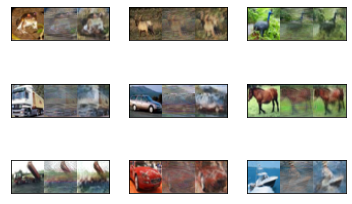

In [148]:
import matplotlib.pyplot as plt

N=3
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_train[idx],0,1),np.clip(X_train_corrupt3[idx],0,1)))
    se2 =  np.hstack((se, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se2)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
pred = model2.predict(X_test_corrupt3)

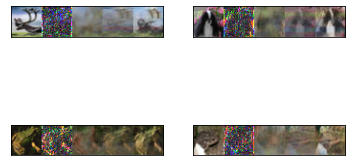

In [160]:
import matplotlib.pyplot as plt

N=2
start_val = 40# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    se = np.hstack((np.clip(x_test[idx],0,1),np.clip(X_test_corrupt[idx],0,1)))
    se2 =  np.hstack((se, np.clip(X_test_corrupt2[idx],0,1)))
    se3 =  np.hstack((se2, np.clip(X_test_corrupt3[idx],0,1)))
    se4 =  np.hstack((se3, np.clip(pred[idx],0,1)))
    axes[row,col].imshow(se4)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

misc

In [0]:
def reconstructAllX3(mag, ang):
    recon = np.zeros(mag.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag[i],ang)
    return recon

In [0]:
noise_phase = np.random.normal(size = x_train[0].shape,loc = 5000, scale = 4000)
print(noise_phase.shape)

(32, 32, 3)


In [0]:
X_train_corrupt = reconstructAllX3(X_train_mag,noise_phase)
X_test_corrupt = reconstructAllX3(X_test_mag,noise_phase)

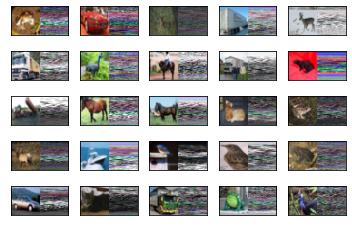

In [0]:
import matplotlib.pyplot as plt

N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train[idx], 0, 1), np.clip(X_train_corrupt[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_corrupt, x_train, batch_size=32, epochs=8, validation_split=0.2)

Epoch 1/8
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1216 - mae: 0.1216 - val_loss: 0.1189 - val_mae: 0.1189
Epoch 2/8
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1191 - mae: 0.1191 - val_loss: 0.1176 - val_mae: 0.1176
Epoch 3/8
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1181 - mae: 0.1181 - val_loss: 0.1172 - val_mae: 0.1172
Epoch 4/8
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1174 - mae: 0.1174 - val_loss: 0.1171 - val_mae: 0.1171
Epoch 5/8
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1168 - mae: 0.1168 - val_loss: 0.1163 - val_mae: 0.1163
Epoch 6/8
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1160 - mae: 0.1160 - val_loss: 0.1170 - val_mae: 0.1170
Epoch 7/8
1250/1250 [==============================] - 35s 28ms/step - loss: 0.1156 - mae: 0.1156 - val_loss: 0.1163 - val_mae: 0.1163
Epoch 8/8
1250/1250 [==============================] - 

In [0]:
pred = model.predict(X_train_corrupt)


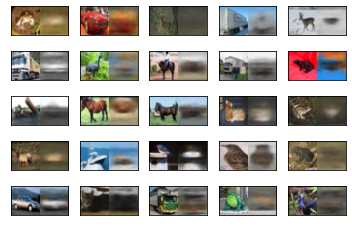

In [0]:
import matplotlib.pyplot as plt

N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train[idx], 0, 1), np.clip(pred[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

A lot of structure missing from the images, although recovery of rough colours seems good. Subjects in the images appear like blobs. Loss of phase info apparent but some reconstruction, mostly in the verticle axis.

In [0]:
def reconstructAllX4(mag, ang):
    recon = np.zeros(ang.shape)
    for i in range(0,recon.shape[0]):
      recon[i,:,:] = reconstruct(mag,ang[i])
    return recon

In [0]:
import random
#random.uniform(0, 1)

noise_mag = np.random.uniform(size = x_train[0].shape,low = 0.0, high = 1.0)
print(noise_mag.shape)

#noise_mag = np.random.normal(size = x_train[0].shape,loc = 0.5, scale = 0.4)
#print(noise_mag.shape)

(32, 32, 3)


In [0]:
X_train_corrupt = reconstructAllX4(noise_mag,X_train_phase)
X_test_corrupt = reconstructAllX4(noise_mag,X_test_phase)

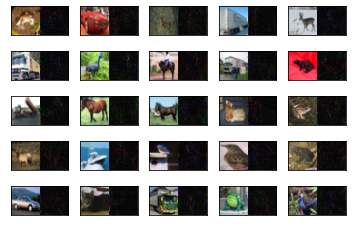

In [0]:
import matplotlib.pyplot as plt

N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train[idx], 0, 1), np.clip(X_train_corrupt[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

In [0]:
model.compile(optimizer = 'Adam', loss = 'mean_absolute_error', metrics = ['mae'])
model.fit(X_train_corrupt, x_train, batch_size=32, epochs=8, validation_split=0.2)

NameError: ignored

In [0]:
pred = model.predict(X_train_corrupt)


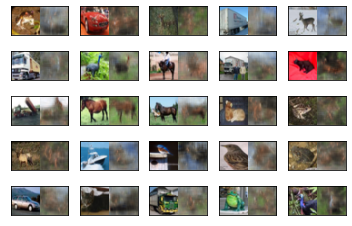

In [0]:
import matplotlib.pyplot as plt

N=5
start_val = 0# pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col
    
    im = np.concatenate((np.clip(x_train[idx], 0, 1), np.clip(pred[idx], 0, 1)), 1)
    axes[row,col].imshow(im)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

Recovers some structure from the image.